In [2]:
"""
Preprocessing code for EDoF-CNN using Fraunhofer database

X-> X_STACKS
Y-> Y_EDF (for each group of X_stacks)
"""


# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--Z', choices=[5], type=int, default=5)
# parser.add_argument('--folds', type=int, choices=range(5),default=5)
# parser.add_argument('--img_size', type=int, choices=[224,512],default=512)
# args = parser.parse_args()

class False_args(object):
    pass
args = False_args()
args.Z = 5
args.folds = 5
args.img_size = 512

import numpy as np
import pandas as pd
import glob
import cv2
import pickle
import os
import _pickle as cPickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
import glob
from os import listdir
from os.path import isfile, join, isdir


mypath=r"/home/van/research/EDoF_FhP/aligned"

geral_dir = [f for f in listdir(mypath) if isdir(join(mypath, f))]

axis_path=[]
Y_EDF=[]
X_STACKS=[]
X_stacks_full=[]

for i in range(len(geral_dir)):
    axis_path=join(mypath,geral_dir[i]) 
    axis_dir = [f for f in listdir(axis_path) if isdir(join(axis_path, f))]
    for ad in axis_dir:
        path=join(mypath,geral_dir[i], ad)
        for idx,image_name in enumerate(glob.glob(join(path,"*.jpg"))):
            img = cv2.imread(image_name)
            img=cv2.resize(img,(args.img_size,args.img_size))
            if os.path.basename(image_name)=='Output.jpg':
                Y_EDF.append(img)

            else:
                X_STACKS.append(img)
                
            
        if os.path.exists(join(path,"output.jpg")):
            pass 
        else:
                print(path)
        if join(path,"output.jpg")==[]:
            print(path)
            
        X_stacks_full.append(X_STACKS)
        X_STACKS=[]







/home/van/research/EDoF_FhP/aligned/Focus_smear08/x3_y12
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x15_y42
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x15_y24
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x12_y39
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x12_y15
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x12_y42
/home/van/research/EDoF_FhP/aligned/Focus_smear08/x3_y15
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x6_y15
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x12_y24
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x9_y12
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x15_y12
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x12_y15
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x3_y18
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x3_y27
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x6_y39
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x6_y18
/home/van/research/EDoF_FhP/aligned/Focus_smear07/x6_y21
/home/van/research/EDoF

In [3]:
Y_EDF = np.array(Y_EDF)
X_STACKS = np.array(X_stacks_full)
X = np.array(X_STACKS)
Y = np.array(Y_EDF)

In [4]:
X_STACKS.shape

(144, 5, 512, 512, 3)

In [5]:
def aff_transform(affine_transformation, input_shape, output_size):
    #
    # original ST affine transformation
    #
    batch_size = tf.shape(input_shape)[0]
    height = tf.shape(input_shape)[1]
    width = tf.shape(input_shape)[2]
    num_channels = tf.shape(input_shape)[3]

    affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

    affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
    affine_transformation = tf.cast(affine_transformation, 'float32')

    width = tf.cast(width, dtype='float32')
    height = tf.cast(height, dtype='float32')
    output_height = output_size[0]
    output_width = output_size[1]
    indices_grid = _meshgrid(output_height, output_width)
    indices_grid = tf.expand_dims(indices_grid, 0)
    indices_grid = tf.reshape(indices_grid, [-1]) # flatten?

    indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
    indices_grid = tf.reshape(indices_grid, (batch_size, 3, -1))

    transformed_grid = tf.matmul(affine_transformation, indices_grid)
    x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
    y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
    x_s_flatten = tf.reshape(x_s, [-1])
    y_s_flatten = tf.reshape(y_s, [-1])

    transformed_image = _interpolate(input_shape, x_s_flatten, y_s_flatten, output_size)

    transformed_image = tf.reshape(transformed_image, shape=(batch_size, output_height, output_width, num_channels))
    #pdb.set_trace()
    return transformed_image

def perform_aff_transformation(image_batch, Ht, output_size, mask=None):
    ##
    ## Perform the affine warping transformation.
    ##
    aug_images = aff_transform(Ht, image_batch, output_size)
    return aug_images

def _meshgrid( height, width):
    x_linspace = tf.linspace(-1., 1., width)
    y_linspace = tf.linspace(-1., 1., height)
    x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
    x_coordinates = tf.reshape(x_coordinates, [-1])
    y_coordinates = tf.reshape(y_coordinates, [-1])
    ones = tf.ones_like(x_coordinates)
    indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
    return indices_grid

def _interpolate( image, x, y, output_size):
    batch_size = tf.shape(image)[0]
    height = tf.shape(image)[1]
    width = tf.shape(image)[2]
    num_channels = tf.shape(image)[3]

    x = tf.cast(x , dtype='float32')
    y = tf.cast(y , dtype='float32')

    height_float = tf.cast(height, dtype='float32')
    width_float = tf.cast(width, dtype='float32')

    output_height = output_size[0]
    output_width  = output_size[1]

    x = .5*(x + 1.0)*(width_float)
    y = .5*(y + 1.0)*(height_float)

    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    max_y = tf.cast(height - 1, dtype='int32')
    max_x = tf.cast(width - 1,  dtype='int32')
    zero = tf.zeros([], dtype='int32')

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    flat_image_dimensions = width*height
    pixels_batch = tf.range(batch_size)*flat_image_dimensions
    flat_output_dimensions = output_height*output_width

    base = _repeat(pixels_batch, flat_output_dimensions)

    base_y0 = base + y0*width
    base_y1 = base + y1*width
    indices_a = base_y0 + x0
    indices_b = base_y1 + x0
    indices_c = base_y0 + x1
    indices_d = base_y1 + x1

    flat_image = tf.reshape(image, shape=(-1, num_channels))
    flat_image = tf.cast(flat_image, dtype='float32')
    pixel_values_a = tf.gather(flat_image, indices_a)
    pixel_values_b = tf.gather(flat_image, indices_b)
    pixel_values_c = tf.gather(flat_image, indices_c)
    pixel_values_d = tf.gather(flat_image, indices_d)

    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
    area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
    area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
    area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
    output = tf.add_n([area_a*pixel_values_a,
                       area_b*pixel_values_b,
                       area_c*pixel_values_c,
                       area_d*pixel_values_d])
    return output
def _repeat( x, num_repeats):
    ones = tf.ones((1, num_repeats), dtype='int32')
    x = tf.reshape(x, shape=(-1,1))
    x = tf.matmul(x, ones)
    return tf.reshape(x, [-1])

In [6]:
import tensorflow as tf
def aug_chromab(image, crop_h, crop_w, scale_val, tx_Rval, ty_Rval, tx_Gval, ty_Gval, tx_Bval, ty_Bval):
    #def aug_chromab(image, wlRarr, wlGarr, wlBarr, sigRarr, sigGarr, sigBarr, batchsize):
    #
    # adjust either longitudinal or lateral chromatic aberration
    # "longtudinal": shift in the direction of the optical axis (scale channels or blur)
    #     - set the value of either scale_x or scale_y set on the order of 0.005
    # "lateral": shift perpendicular to the optical axis, in the plane of the sensor or film (shift color channels) 
    #     - set the value of either tx or ty set on the order of 0.005
    #
    # longitudinal chromatic aberration: scale the green channel
    # lateral chromatic aberration: translate the channels
    #

    # normalize image to 0-1 range, convert to float
    image_ = tf.image.convert_image_dtype(image/255.0, tf.float32)
    # split the image into its channels
    R,G,B = tf.split(image_, 3, axis=3)
    #
    ## METHOD: IMAGE CHANNEL WARPING
    ## the below code generates a specific Hi for each channel
    ## red channel parameters
    R_alpha1 = tf.ones_like(tx_Rval)     #scale_r*math.cos(theta_r) # sx*r1
    R_alpha2 = tf.zeros_like(tx_Rval)     #-shear_r*math.sin(theta_r)# Sx*r2
    R_alpha3 = tx_Rval #tx
    R_alpha4 = tf.zeros_like(tx_Rval)    #shear_r*math.sin(theta_r) #sy*r4
    R_alpha5 = tf.ones_like(tx_Rval)    #scale_r*math.cos(theta_r) # Sy*r3  
    R_alpha6 = ty_Rval #ty
    # green channel parameters
    G_alpha1 = scale_val  #scale_g*math.cos(theta_g) # sx*r1
    G_alpha2 = tf.zeros_like(tx_Gval)        #-shear_g*math.sin(theta_g)# Sx*r2
    G_alpha3 = tx_Gval    #tx 
    G_alpha4 = tf.zeros_like(tx_Rval)        #shear_g*math.sin(theta_g) # sy*r4
    G_alpha5 = scale_val  #scale_g*math.cos(theta_g) # Sy*r3
    G_alpha6 = ty_Gval    #ty
    # blue channel parameters
    B_alpha1 = tf.ones_like(tx_Rval)     #scale_b*math.cos(theta_b) # sx*r1
    B_alpha2 = tf.zeros_like(tx_Bval)    #-shear_b*math.sin(theta_b)# Sx*r2
    B_alpha3 = tx_Bval                   #tx  
    B_alpha4 = tf.zeros_like(tx_Bval)    #shear_b*math.sin(theta_b) # sy*r4
    B_alpha5 = tf.ones_like(tx_Rval)     #scale_b*math.cos(theta_b) # Sy*r3 
    B_alpha6 = tx_Bval # ty
    ##
    num_aff_params = 6
    HRt = tf.stack([R_alpha1, R_alpha2, R_alpha3, R_alpha4, R_alpha5, R_alpha6], axis = 1)
    HGt = tf.stack([G_alpha1, G_alpha2, G_alpha3, G_alpha4, G_alpha5, G_alpha6], axis = 1)
    HBt = tf.stack([B_alpha1, B_alpha2, B_alpha3, B_alpha4, B_alpha5, B_alpha6], axis = 1)
    #
    # use the  spatial transformer layer to perform the affine warping on each channel for each image in the image batch
    augR = perform_aff_transformation(R, HRt, (crop_h, crop_w))
    augG = perform_aff_transformation(G, HGt, (crop_h, crop_w))
    augB = perform_aff_transformation(B, HBt, (crop_h, crop_w))
    #
    augimage = tf.concat([augR,augG,augB], axis =3)
    #
    # clip
    augimage = tf.clip_by_value(augimage,0.0,1.0)
    # scale image back into 0-255 range
    augimage = tf.multiply(augimage,255.0)
    # return augmented image
    return augimage

2023-06-28 12:32:02.654237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-28 12:32:02.654399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-28 12:32:02.654500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-28 12:32:02.679518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 12:32:03.846684: W tensorflow/compiler/

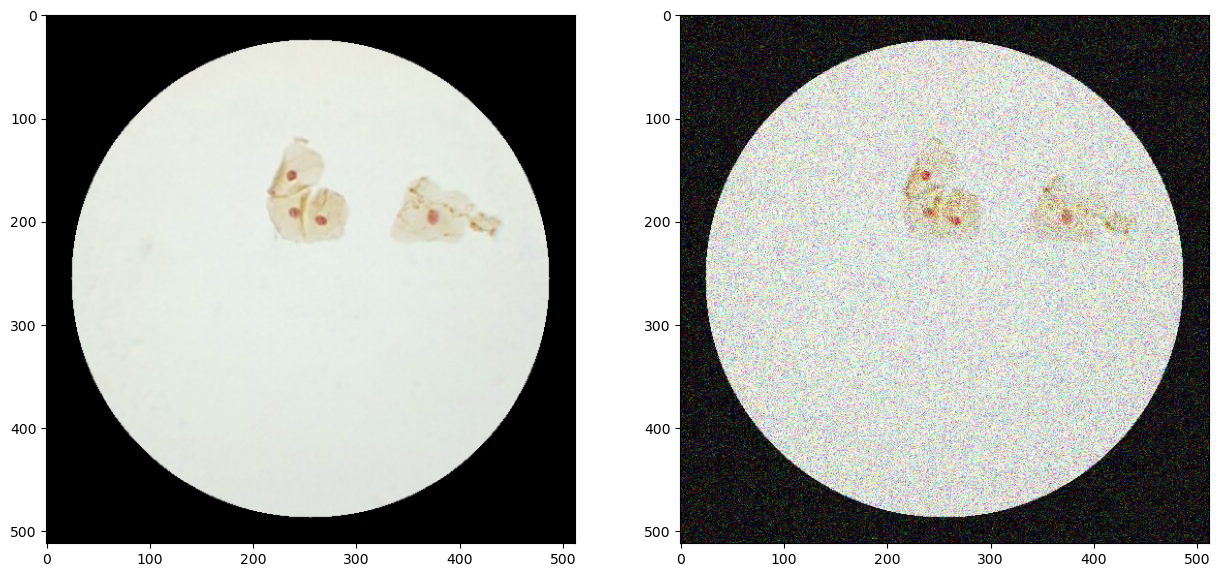

In [7]:
from skimage.util import random_noise
from matplotlib import pyplot as plt

test_img = X[0][1]
aumented_img = random_noise(test_img,var=0.2**2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(test_img)
ax2.imshow(aumented_img)

In [8]:
batchsize = 1
scale_val = tf.random.uniform((batchsize,1,1,1), minval = 1, maxval = 1, dtype=tf.float32)
minT = 0
maxT = 0
tx_Rval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)
ty_Rval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)
tx_Gval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)  
ty_Gval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)
tx_Bval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)  
ty_Bval = tf.random.uniform((batchsize,1,1,1), minval=minT, maxval = maxT, dtype=tf.float32)

2023-06-28 12:32:20.861354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 12:32:20.964388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 12:32:20.965217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 12:32:20.969152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 12:32:20.970217: I tensorflow/compile

In [9]:
batch_img = tf.expand_dims(test_img, axis=0)
float_img = tf.image.convert_image_dtype(batch_img, tf.float32)
crop_h = test_img.shape[0]
crop_w = test_img.shape[1]

In [10]:
augImg = aug_chromab(float_img, crop_h, crop_w, scale_val, tx_Rval, ty_Rval, tx_Gval, ty_Gval, tx_Bval, ty_Bval)

2023-06-28 12:32:28.247469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [11]:
reshaped = np.array(augImg[0])
reshaped = reshaped * 255
reshaped = reshaped.astype(np.uint8)

In [12]:
reshaped.shape
np.array([reshaped]).shape

(1, 512, 512, 3)

In [13]:
test_img.dtype

dtype('uint8')

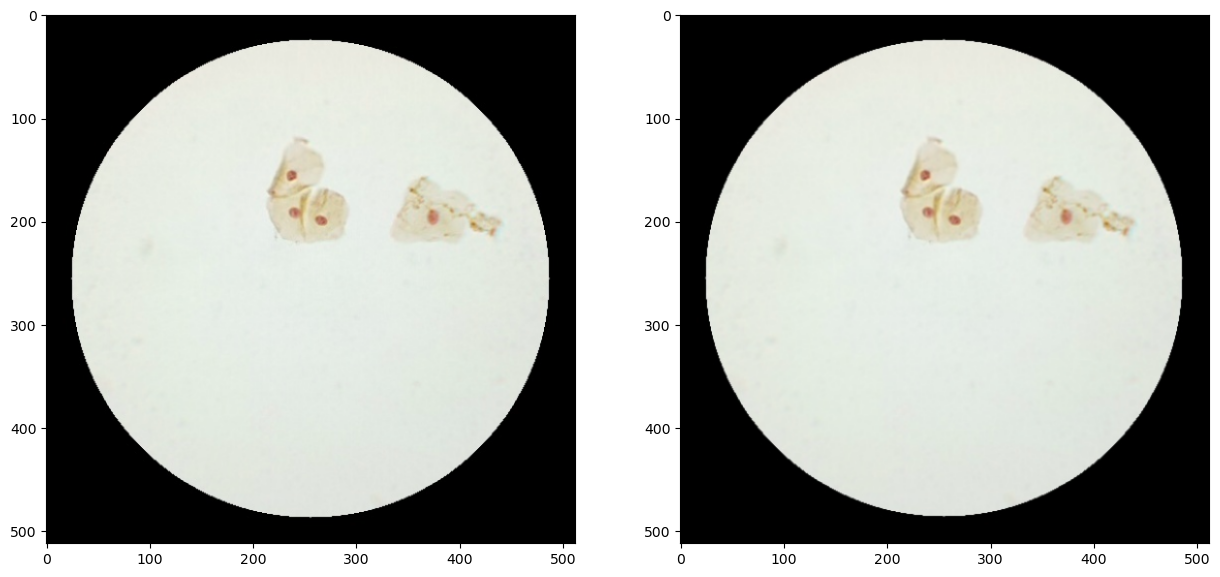

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(test_img)
ax2.imshow(reshaped)

In [17]:
grey = tf.image.rgb_to_grayscale(reshaped)
grey.shape

TensorShape([512, 512, 1])

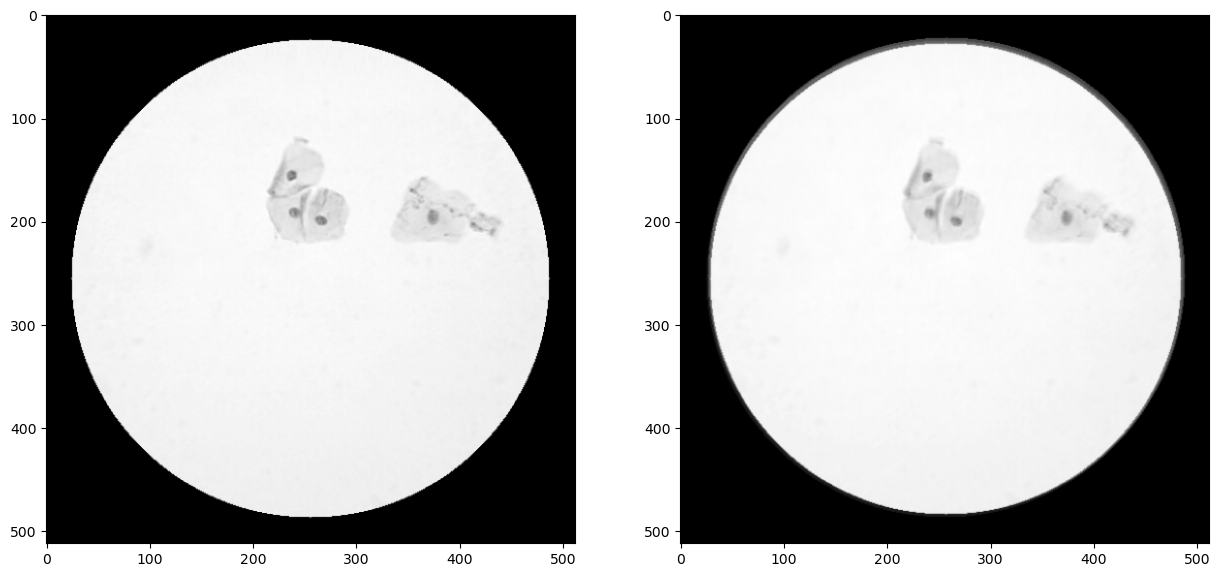

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(tf.image.rgb_to_grayscale(test_img),cmap='gray')
ax2.imshow(grey,cmap='gray')

In [53]:
# # kfold
state = np.random.RandomState(1234)
kfold = KFold(args.folds, shuffle=True, random_state=state)
folds = [{'train': (X[tr], Y[tr]), 'test': (X[ts], Y[ts])} 
    for tr, ts in kfold.split(X, Y)]


In [ ]:
pickle.dump(folds, open(f'data_fraunhofer_no_rgb_elastic.pickle', 'wb'))